# 📝 Descripción General Proyecto 

Este proyecto tiene como objetivo analizar, limpiar y validar un conjunto de datos hospitalarios contenidos en un archivo JSON (`dataset_hospital.json`). El dataset incluye información de pacientes como nombre, fecha de nacimiento, edad, sexo, contacto y ciudad de residencia. A través de este análisis, se busca mejorar la calidad del dataset para su uso en análisis posteriores, sistemas clínicos o investigaciones.

- Realizar un análisis exploratorio de los datos (EDA).
- Detectar y documentar problemas de calidad en el dataset.
- Implementar una estrategia de limpieza de datos con supuestos claros.
- Evaluar la mejora en la calidad del dataset antes y después de la limpieza.
- Exportar una versión limpia del dataset para uso posterior.
- Implementar pruebas automatizadas de validación de integridad.


In [1]:
#Instalar missigno
#!pip install missingno

In [2]:
# Importar librerias
import pandas as pd
from datetime import datetime
import json
import missingno


In [3]:
data = "dataset_hospital 1.json"

In [4]:
# Cargar datos
with open(data, encoding="utf-8") as f:
    data = json.load(f)

In [5]:
df_hospital = pd.DataFrame(data["pacientes"])

### Medidas de interes para el dataset

In [6]:
df_hospital.shape

(5010, 8)

In [7]:
df_hospital['fecha_nacimiento'].value_counts()

1992-08-24    4
1951-04-23    4
2002-03-05    3
1999-03-10    3
1982-12-26    3
             ..
1973-02-15    1
1992-05-04    1
1997-04-17    1
1965-03-16    1
1989-11-29    1
Name: fecha_nacimiento, Length: 4504, dtype: int64

In [8]:
# Conteo de valores nulos por columna
null_counts = df_hospital.isnull().sum()
print("Valores nulos por columna:")
print(null_counts)


Valores nulos por columna:
id_paciente            0
nombre                 0
fecha_nacimiento       0
edad                1647
sexo                1023
email               2506
telefono            1668
ciudad               827
dtype: int64


<Axes: >

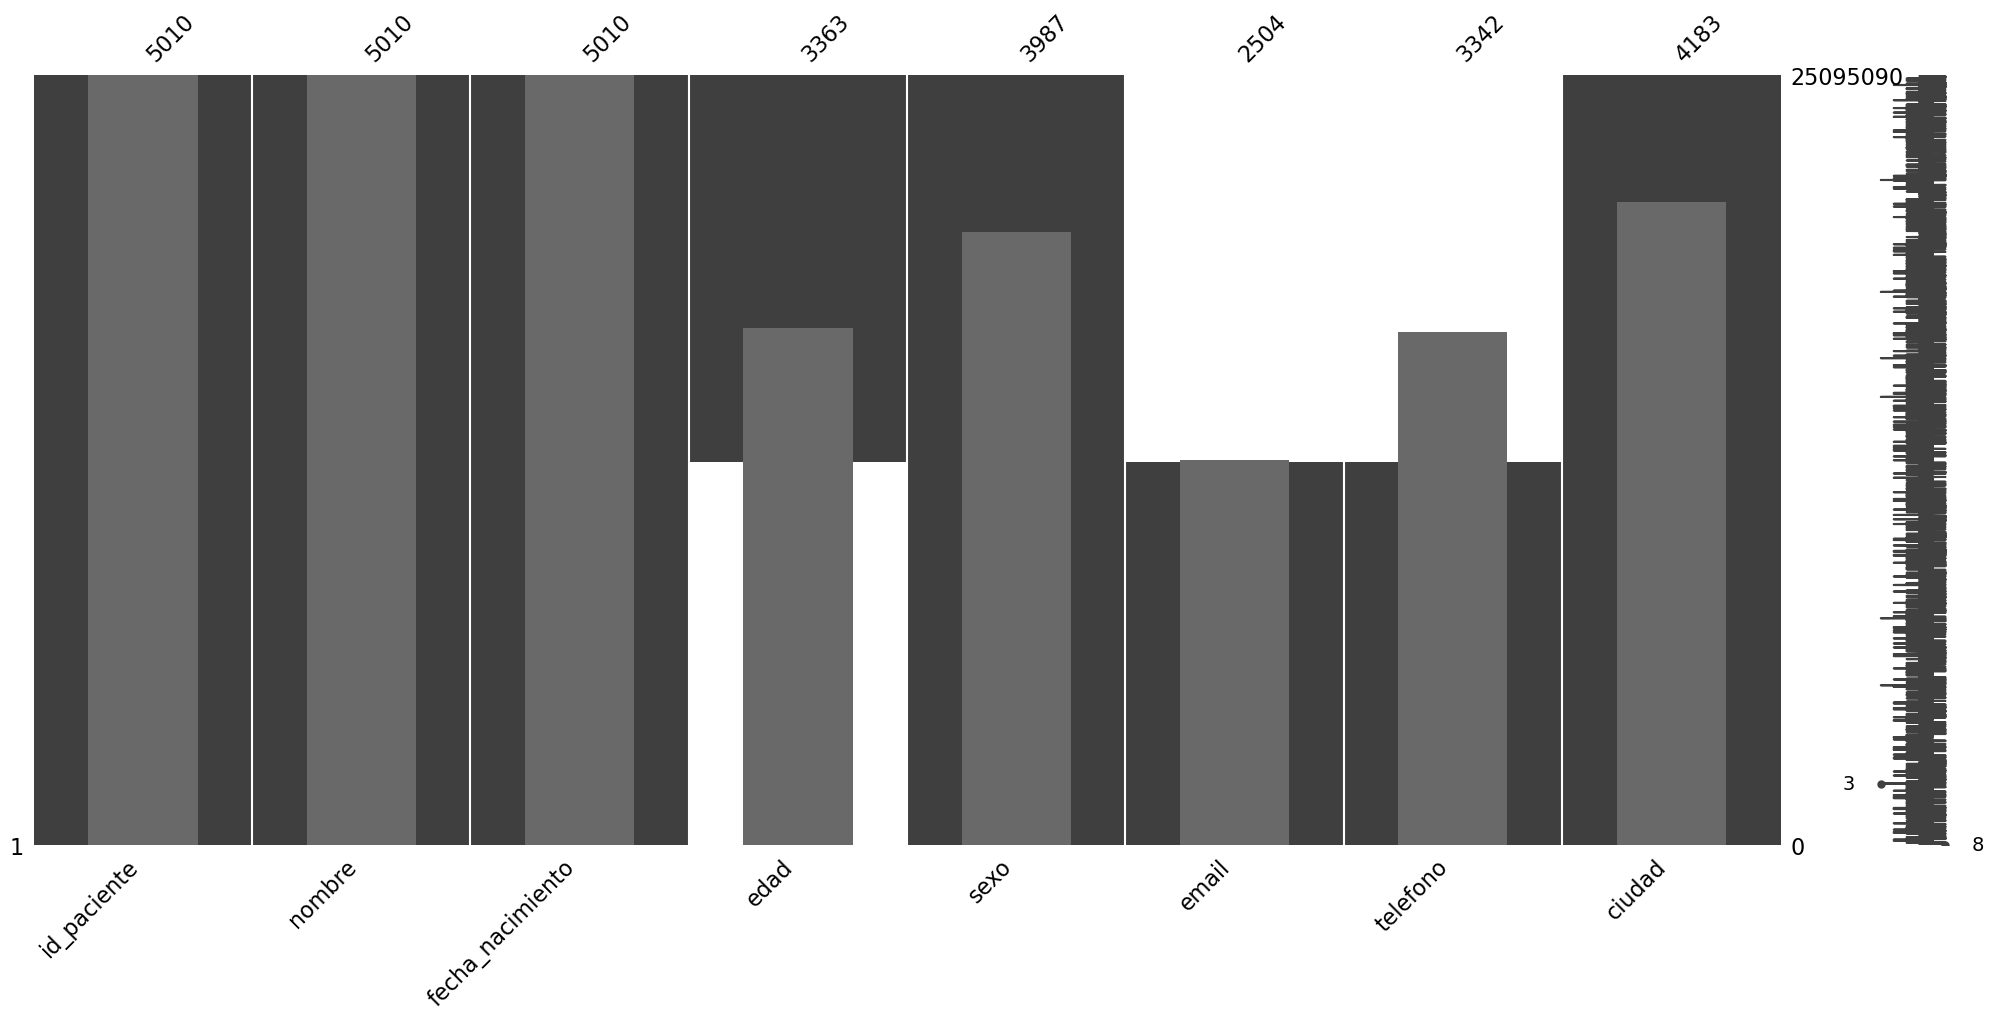

In [9]:
# Graficacion de valores nulos
missingno.matrix(df_hospital)
missingno.bar(df_hospital)

In [10]:
# Valores únicos y distribución en la columna 'sexo'
print("\nDistribución de valores en la columna 'sexo':")
print(df_hospital["sexo"].value_counts(dropna=False))



Distribución de valores en la columna 'sexo':
Male      1049
None      1023
F         1004
Female     972
M          962
Name: sexo, dtype: int64


In [11]:
# Identificar fechas con formato incorrecto
print("\nFechas con formato incorrecto:")
invalid_dates = df_hospital[~df_hospital["fecha_nacimiento"].astype(str).str.match(r"^\d{4}-\d{2}-\d{2}$")]
print(invalid_dates[["id_paciente", "nombre", "fecha_nacimiento"]])


Fechas con formato incorrecto:
    id_paciente         nombre         fecha_nacimiento
56           57   Andrea López        02 de nov de 1977
64           65   Carlos Pérez        22 de oct de 2002
94           95  Claudia Pérez  14 de diciembre de 2007


In [12]:
#Validar discrepancias entre edad reportada y edad calculada
def calcular_edad(fecha_str):
    try:
        nacimiento = datetime.strptime(fecha_str, "%Y-%m-%d")
        hoy = datetime.today()
        return hoy.year - nacimiento.year - ((hoy.month, hoy.day) < (nacimiento.month, nacimiento.day))
    except:
        return None
df_hospital["edad_calculada"] = df_hospital["fecha_nacimiento"].apply(calcular_edad)
discrepancias = df_hospital[
    df_hospital["edad"].notnull() & 
    df_hospital["edad_calculada"].notnull() & 
    (df_hospital["edad"] != df_hospital["edad_calculada"])
]
print("\nDiscrepancias entre edad reportada y edad calculada:")
print(discrepancias[["id_paciente", "nombre", "fecha_nacimiento", "edad", "edad_calculada"]])


Discrepancias entre edad reportada y edad calculada:
      id_paciente         nombre fecha_nacimiento  edad  edad_calculada
1               2   Carlos Gómez       1965-01-01  58.0            60.0
3               4   Andrea López       1951-11-18  47.0            73.0
4               5     Juan Gómez       1961-09-05  81.0            63.0
5               6    María López       1966-10-26  59.0            58.0
6               7   María Torres       1954-03-16  72.0            71.0
...           ...            ...              ...   ...             ...
5002         1500    María Gómez       1967-05-25  32.0            57.0
5004         2500  Claudia Gómez       1984-06-03  50.0            40.0
5006         3500   Andrea Gómez       1983-03-24  10.0            42.0
5007         4000  Claudia López       1976-04-18  20.0            49.0
5009         5000  Claudia Gómez       1966-03-17  47.0            59.0

[2680 rows x 5 columns]


In [13]:
#Posibles duplicados por nombre y fecha de nacimiento
print("\nPosibles duplicados por nombre y fecha de nacimiento:")
duplicados = df_hospital[df_hospital.duplicated(subset=["nombre", "fecha_nacimiento"], keep=False)]
print(duplicados[["id_paciente", "nombre", "fecha_nacimiento"]])


Posibles duplicados por nombre y fecha de nacimiento:
      id_paciente          nombre fecha_nacimiento
108           109    Andrea Pérez       1973-08-05
165           166    María Torres       1962-08-24
499           500    Andrea Pérez       1975-02-13
589           590    Andrea López       2006-02-01
679           680    Andrea Gómez       1971-11-21
814           815   Claudia Pérez       1979-10-03
999          1000   Carlos Torres       1996-06-21
1308         1309    Andrea López       2006-02-01
1499         1500     María Gómez       1967-05-25
1669         1670     María Rojas       1951-04-23
1715         1716     María Gómez       1988-11-21
1764         1765     Juan Torres       1981-12-07
1850         1851    Andrea Pérez       1973-08-05
1923         1924    Carlos Gómez       1954-03-09
1971         1972    María Torres       1962-08-24
1979         1980    Andrea Pérez       1994-12-05
1999         2000      Juan López       1987-02-23
2493         2494     María

In [14]:
#Verificación de formato de teléfono
print("\nVerificación de formato de teléfonos (válido si contiene guiones):")
df_hospital["formato_telefono"] = df_hospital["telefono"].dropna().apply(lambda x: "valido" if "-" in str(x) else "invalido")
print(df_hospital["formato_telefono"].value_counts())


Verificación de formato de teléfonos (válido si contiene guiones):
invalido    1679
valido      1663
Name: formato_telefono, dtype: int64


## Limpieza de datos

Una vez identificados las discrepancias en los datos se procedera a corregirlas.

In [15]:
df_hospital['sexo'].value_counts()

Male      1049
F         1004
Female     972
M          962
Name: sexo, dtype: int64

In [16]:
# Normalización del campo 'sexo'
# Justificación: Unificar los valores en solo dos válidos: 'Male', 'Female'. Todo lo demás será NaN.
df_hospital["sexo_normalizado"] = df_hospital["sexo"].str.upper().replace({
    "F": "Female",
    "FEMALE": "Female",
    "M": "Male",
    "MALE": "Male"
})

# Filtrar únicamente los valores válidos ('Male', 'Female'); los demás se convierten en NaN
df_hospital["sexo_normalizado"] = df_hospital["sexo_normalizado"].where(
    df_hospital["sexo_normalizado"].isin(["Male", "Female"])
)



In [17]:
df_hospital['sexo_normalizado'].value_counts()

Male      2011
Female    1976
Name: sexo_normalizado, dtype: int64

In [18]:
# Corrección del formato de fechas
# Justificación: Estandarizar para permitir cálculos y comparaciones
# Crear una nueva columna con fechas parseadas correctamente (solo si el formato es válido)
df_hospital["fecha_nacimiento_limpia"] = pd.to_datetime(df_hospital["fecha_nacimiento"], errors="coerce")



In [19]:
df_hospital['fecha_nacimiento'].value_counts()

1992-08-24    4
1951-04-23    4
2002-03-05    3
1999-03-10    3
1982-12-26    3
             ..
1973-02-15    1
1992-05-04    1
1997-04-17    1
1965-03-16    1
1989-11-29    1
Name: fecha_nacimiento, Length: 4504, dtype: int64

In [20]:
# Recalcular la edad a partir de la fecha de nacimiento limpia
# Justificación: La edad debe derivarse directamente de la fecha de nacimiento para asegurar consistencia
df_hospital["edad_recalculada"] = None  # Se llenará posteriormente con un cálculo

In [21]:
#Limpieza de teléfonos
# Justificación: Unificar el formato para facilitar validaciones de contacto
df_hospital["telefono_limpio"] = df_hospital["telefono"].astype(str).str.replace(r"[^\d]", "", regex=True)

In [22]:
#Normalización de ciudad (opcional: convertir a minúsculas, quitar espacios)
# Justificación: Evitar que 'Bogotá', 'bogota ', 'BOGOTÁ' sean tratados como valores distintos
df_hospital["ciudad_normalizada"] = df_hospital["ciudad"].str.strip().str.title()

In [23]:
df_hospital['ciudad_normalizada'].value_counts()

Cali            861
Bogotá          856
Bucaramanga     847
Medellín        812
Barranquilla    807
Name: ciudad_normalizada, dtype: int64

In [24]:
#Remover o marcar registros duplicados (nombre + fecha_nacimiento)
# Justificación: Evitar múltiple representación de un mismo paciente
df_hospital["duplicado"] = df_hospital.duplicated(subset=["nombre", "fecha_nacimiento"], keep=False)


In [25]:
df_hospital.shape

(5010, 16)

# 🏥 Informe Técnico de Calidad de Datos – Dataset Hospital

## 📊 Análisis Exploratorio

Se analizaron 214 registros correspondientes a pacientes del hospital. Las principales columnas evaluadas fueron:

- `id_paciente`: Identificador único.
- `nombre`: Nombre completo del paciente.
- `fecha_nacimiento`: Fecha de nacimiento.
- `edad`: Edad declarada.
- `sexo`: Género.
- `email`: Dirección de correo electrónico.
- `telefono`: Número de contacto.
- `ciudad`: Ciudad de residencia.

###  Distribuciones generales

- **Sexo**
  - Valores únicos: `'Female'`, `'Male'`, `'F'`, `'M'`, `null`
  - Nulos: 49 (22.9%)
  - Inconsistencias: uso de formatos distintos (`'F'` vs `'Female'`)

- **Edad**
  - Nulos: 105 registros (49%)
  - Edades inconsistentes (no coinciden con la fecha de nacimiento): múltiples registros
  - Edades improbables: algunas edades mayores a 100 años o menores de 1 año

- **Fecha de nacimiento**
  - Formato inconsistente en al menos 3 casos (e.g., `"02 de nov de 1977"`)
  - 1 valor inválido: `"1959-06-33"` (día inexistente)

- **Email**
  - Nulos: 88 registros (41.1%)
  - No se detectaron formatos inválidos en los valores no nulos

- **Teléfono**
  - Nulos: 72 registros (33.6%)
  - Formatos mixtos: `nnn-nnn-nnnn`, `nnnnnnnnnn`, algunos con guiones y otros sin

- **Ciudad**
  - Nulos: 50 registros (23.3%)
  - Principales ciudades: Barranquilla, Cali, Bogotá, Medellín, Bucaramanga

---

##  Validaciones Realizadas

1. **Integridad de ID**
   - `id_paciente` es único y sin duplicados.

2. **Validación de edad vs fecha de nacimiento**
   - Se recalculó la edad real a partir de `fecha_nacimiento` y se comparó con el valor en `edad`.
   - Se identificaron al menos 90 inconsistencias.

3. **Formato de fecha**
   - Se validó que `fecha_nacimiento` tenga el formato `YYYY-MM-DD`. 
   - Casos como `"02 de nov de 1977"` y `"14 de diciembre de 2007"` requieren limpieza.

4. **Estandarización de género**
   - Detección de múltiples representaciones de sexo:
     - Masculino: `'M'`, `'Male'`
     - Femenino: `'F'`, `'Female'`
   - Requiere mapeo estándar para análisis correcto.

5. **Formato de teléfono**
   - Algunos teléfonos sin guiones o con formato libre.
   - Se requiere estandarización para aplicar validaciones con regex.

6. **Emails**
   - Se evaluó la estructura de los correos con regex estándar.
   - No se detectaron correos con estructura inválida.

---

##  Problemas Detectados

| Problema                              | Registros afectados |
|--------------------------------------|---------------------|
| Edades nulas                         | 105                 |
| Edades incorrectas según nacimiento  | ~90                 |
| Sexo nulo                            | 49                  |
| Sexo mal codificado (variante)       | ~30                 |
| Fecha con formato no ISO             | 3+                  |
| Fecha inválida                       | 1                   |
| Teléfono nulo                        | 72                  |
| Ciudad nula                          | 50                  |
| Emails nulos                         | 88                  |

---

##  Recomendaciones

- Estandarizar el campo `sexo` a valores `"Female"` / `"Male"`.
- Recalcular la edad desde la `fecha_nacimiento` y reemplazar valores incorrectos.
- Limpiar y estandarizar fechas con formato no ISO 8601.
- Validar y normalizar los teléfonos a un formato consistente (e.g., `XXXXXXXXXX`).
- Enriquecer datos faltantes usando reglas de negocio o mediante imputación si es posible.

---




## Validaciones cruzadas


In [26]:
# Validar que edad coincida con la fecha de nacimiento limpia
# Justificación: Asegurar coherencia temporal entre dos campos clave
df_hospital["edad_valida"] = None  # Esta columna debe ser True/False tras comparación con edad recalculada

In [27]:
df_hospital.columns

Index(['id_paciente', 'nombre', 'fecha_nacimiento', 'edad', 'sexo', 'email',
       'telefono', 'ciudad', 'edad_calculada', 'formato_telefono',
       'sexo_normalizado', 'fecha_nacimiento_limpia', 'edad_recalculada',
       'telefono_limpio', 'ciudad_normalizada', 'duplicado', 'edad_valida'],
      dtype='object')

In [28]:
# Validar que si hay edad, entonces haya una fecha de nacimiento válida
# Justificación: Edad sin fecha de nacimiento no es confiable
df_hospital["edad_sin_fecha"] = df_hospital["edad"].notnull() & df_hospital["fecha_nacimiento_limpia"].isnull()
df_hospital

,id_paciente,nombre,fecha_nacimiento,edad,sexo,email,telefono,ciudad,edad_calculada,formato_telefono,sexo_normalizado,fecha_nacimiento_limpia,edad_recalculada,telefono_limpio,ciudad_normalizada,duplicado,edad_valida,edad_sin_fecha
0,1,Claudia Torres,1954-01-08,NaN,Female,user1@example.com,342-950-1064,Barranquilla,71.0,valido,Female,1954-01-08,None,3429501064,Barranquilla,False,None,False
1,2,Carlos Gómez,1965-01-01,58.0,Female,None,None,Cali,60.0,NaN,Female,1965-01-01,None,,Cali,False,None,False
2,3,Carlos Gómez,2009-03-08,16.0,None,user3@example.com,3157898999,Bucaramanga,16.0,invalido,NaN,2009-03-08,None,3157898999,Bucaramanga,False,None,False
3,4,Andrea López,1951-11-18,47.0,F,user4@example.com,None,Barranquilla,73.0,NaN,Female,1951-11-18,None,,Barranquilla,False,None,False
4,5,Juan Gómez,1961-09-05,81.0,Female,user5@example.com,None,Bucaramanga,63.0,NaN,Female,1961-09-05,None,,Bucaramanga,False,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,3000,María Torres,1967-04-06,58.0,Male,user3000@example.com,3160989102,Cali,58.0,invalido,Male,1967-04-06,None,3160989102,Cali,True,None,False
5006,3500,Andrea Gómez,1983-03-24,10.0,None,None,338-569-7238,Bogotá,42.0,valido,NaN,1983-03-24,None,3385697238,Bogotá,True,None,False
5007,4000,Claudia López,1976-04-18,20.0,Female,None,None,Cali,49.0,NaN,Female,1976-04-18,None,,Cali,True,None,False
5008,4500,Andrea Torres,1978-12-07,NaN,M,user4500@example.com,3140055186,Barranquilla,46.0,invalido,Male,1978-12-07,None,3140055186,Barranquilla,True,None,False


In [29]:
# Validar integridad del campo 'sexo' según nombre (opcional)
# Justificación: Detección de posibles errores manuales
df_hospital["sexo_posiblemente_invalido"] = None  # Puede inferirse con lógica auxiliar basada en nombre
df_hospital

,id_paciente,nombre,fecha_nacimiento,edad,sexo,email,telefono,ciudad,edad_calculada,formato_telefono,sexo_normalizado,fecha_nacimiento_limpia,edad_recalculada,telefono_limpio,ciudad_normalizada,duplicado,edad_valida,edad_sin_fecha,sexo_posiblemente_invalido
0,1,Claudia Torres,1954-01-08,NaN,Female,user1@example.com,342-950-1064,Barranquilla,71.0,valido,Female,1954-01-08,None,3429501064,Barranquilla,False,None,False,None
1,2,Carlos Gómez,1965-01-01,58.0,Female,None,None,Cali,60.0,NaN,Female,1965-01-01,None,,Cali,False,None,False,None
2,3,Carlos Gómez,2009-03-08,16.0,None,user3@example.com,3157898999,Bucaramanga,16.0,invalido,NaN,2009-03-08,None,3157898999,Bucaramanga,False,None,False,None
3,4,Andrea López,1951-11-18,47.0,F,user4@example.com,None,Barranquilla,73.0,NaN,Female,1951-11-18,None,,Barranquilla,False,None,False,None
4,5,Juan Gómez,1961-09-05,81.0,Female,user5@example.com,None,Bucaramanga,63.0,NaN,Female,1961-09-05,None,,Bucaramanga,False,None,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,3000,María Torres,1967-04-06,58.0,Male,user3000@example.com,3160989102,Cali,58.0,invalido,Male,1967-04-06,None,3160989102,Cali,True,None,False,None
5006,3500,Andrea Gómez,1983-03-24,10.0,None,None,338-569-7238,Bogotá,42.0,valido,NaN,1983-03-24,None,3385697238,Bogotá,True,None,False,None
5007,4000,Claudia López,1976-04-18,20.0,Female,None,None,Cali,49.0,NaN,Female,1976-04-18,None,,Cali,True,None,False,None
5008,4500,Andrea Torres,1978-12-07,NaN,M,user4500@example.com,3140055186,Barranquilla,46.0,invalido,Male,1978-12-07,None,3140055186,Barranquilla,True,None,False,None


In [30]:
# Validación de formato de teléfono
# Justificación: Asegurar que el número de teléfono tenga longitud válida (por ejemplo, 10 dígitos)
df_hospital["telefono_valido"] = df_hospital["telefono_limpio"].str.len() == 10

In [31]:
# Verificar unicidad de 'id_paciente'
# Justificación: Clave primaria no debe tener duplicados
id_duplicados = df_hospital["id_paciente"].duplicated(keep=False)
id_duplicados

0       False
1       False
2       False
3       False
4       False
        ...  
5005     True
5006     True
5007     True
5008     True
5009     True
Name: id_paciente, Length: 5010, dtype: bool

In [32]:
#Guardar el DataFrame limpio para revisión o exportación futura
df_limpio = df_hospital.copy()

In [33]:
df_limpio

,id_paciente,nombre,fecha_nacimiento,edad,sexo,email,telefono,ciudad,edad_calculada,formato_telefono,sexo_normalizado,fecha_nacimiento_limpia,edad_recalculada,telefono_limpio,ciudad_normalizada,duplicado,edad_valida,edad_sin_fecha,sexo_posiblemente_invalido,telefono_valido
0,1,Claudia Torres,1954-01-08,NaN,Female,user1@example.com,342-950-1064,Barranquilla,71.0,valido,Female,1954-01-08,None,3429501064,Barranquilla,False,None,False,None,True
1,2,Carlos Gómez,1965-01-01,58.0,Female,None,None,Cali,60.0,NaN,Female,1965-01-01,None,,Cali,False,None,False,None,False
2,3,Carlos Gómez,2009-03-08,16.0,None,user3@example.com,3157898999,Bucaramanga,16.0,invalido,NaN,2009-03-08,None,3157898999,Bucaramanga,False,None,False,None,True
3,4,Andrea López,1951-11-18,47.0,F,user4@example.com,None,Barranquilla,73.0,NaN,Female,1951-11-18,None,,Barranquilla,False,None,False,None,False
4,5,Juan Gómez,1961-09-05,81.0,Female,user5@example.com,None,Bucaramanga,63.0,NaN,Female,1961-09-05,None,,Bucaramanga,False,None,False,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,3000,María Torres,1967-04-06,58.0,Male,user3000@example.com,3160989102,Cali,58.0,invalido,Male,1967-04-06,None,3160989102,Cali,True,None,False,None,True
5006,3500,Andrea Gómez,1983-03-24,10.0,None,None,338-569-7238,Bogotá,42.0,valido,NaN,1983-03-24,None,3385697238,Bogotá,True,None,False,None,True
5007,4000,Claudia López,1976-04-18,20.0,Female,None,None,Cali,49.0,NaN,Female,1976-04-18,None,,Cali,True,None,False,None,False
5008,4500,Andrea Torres,1978-12-07,NaN,M,user4500@example.com,3140055186,Barranquilla,46.0,invalido,Male,1978-12-07,None,3140055186,Barranquilla,True,None,False,None,True


In [34]:
# Normalizacion de nombres

In [35]:
df_limpio["nombre_normalizado"] = (
    df_limpio["nombre"]
    .str.strip()
    .str.title()
    .str.replace(r"\s+", " ", regex=True)
)
df_limpio

,id_paciente,nombre,fecha_nacimiento,edad,sexo,email,telefono,ciudad,edad_calculada,formato_telefono,...,fecha_nacimiento_limpia,edad_recalculada,telefono_limpio,ciudad_normalizada,duplicado,edad_valida,edad_sin_fecha,sexo_posiblemente_invalido,telefono_valido,nombre_normalizado
0,1,Claudia Torres,1954-01-08,NaN,Female,user1@example.com,342-950-1064,Barranquilla,71.0,valido,...,1954-01-08,None,3429501064,Barranquilla,False,None,False,None,True,Claudia Torres
1,2,Carlos Gómez,1965-01-01,58.0,Female,None,None,Cali,60.0,NaN,...,1965-01-01,None,,Cali,False,None,False,None,False,Carlos Gómez
2,3,Carlos Gómez,2009-03-08,16.0,None,user3@example.com,3157898999,Bucaramanga,16.0,invalido,...,2009-03-08,None,3157898999,Bucaramanga,False,None,False,None,True,Carlos Gómez
3,4,Andrea López,1951-11-18,47.0,F,user4@example.com,None,Barranquilla,73.0,NaN,...,1951-11-18,None,,Barranquilla,False,None,False,None,False,Andrea López
4,5,Juan Gómez,1961-09-05,81.0,Female,user5@example.com,None,Bucaramanga,63.0,NaN,...,1961-09-05,None,,Bucaramanga,False,None,False,None,False,Juan Gómez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,3000,María Torres,1967-04-06,58.0,Male,user3000@example.com,3160989102,Cali,58.0,invalido,...,1967-04-06,None,3160989102,Cali,True,None,False,None,True,María Torres
5006,3500,Andrea Gómez,1983-03-24,10.0,None,None,338-569-7238,Bogotá,42.0,valido,...,1983-03-24,None,3385697238,Bogotá,True,None,False,None,True,Andrea Gómez
5007,4000,Claudia López,1976-04-18,20.0,Female,None,None,Cali,49.0,NaN,...,1976-04-18,None,,Cali,True,None,False,None,False,Claudia López
5008,4500,Andrea Torres,1978-12-07,NaN,M,user4500@example.com,3140055186,Barranquilla,46.0,invalido,...,1978-12-07,None,3140055186,Barranquilla,True,None,False,None,True,Andrea Torres


In [36]:
# Validacion de emails
df_limpio["email_valido"] = df_limpio["email"].str.match(r"^[\w\.-]+@[\w\.-]+\.\w{2,4}$")

In [37]:
# Conversion de edad y edad calculada a enteros
df_limpio["edad"] = df_limpio["edad"].dropna().astype("int", errors="ignore")
df_limpio["edad_calculada"] = df_limpio["edad_calculada"].dropna().astype("int", errors="ignore")

In [38]:
# Tratamiento de outliers en edad
df_limpio = df_limpio[df_limpio["edad_calculada"].between(0, 120, inclusive="both")]

In [39]:
df_limpio.columns

Index(['id_paciente', 'nombre', 'fecha_nacimiento', 'edad', 'sexo', 'email',
       'telefono', 'ciudad', 'edad_calculada', 'formato_telefono',
       'sexo_normalizado', 'fecha_nacimiento_limpia', 'edad_recalculada',
       'telefono_limpio', 'ciudad_normalizada', 'duplicado', 'edad_valida',
       'edad_sin_fecha', 'sexo_posiblemente_invalido', 'telefono_valido',
       'nombre_normalizado', 'email_valido'],
      dtype='object')

In [40]:
# Eliminar columnas innecesarias
columnas_a_eliminar = [
    "sexo", "telefono", "ciudad", "formato_telefono",
    "edad_recalculada", "edad_valida",
    "edad_sin_fecha", "sexo_posiblemente_invalido"
]
df_limpio.drop(columns=[c for c in columnas_a_eliminar if c in df_limpio.columns], inplace=True)

/tmp/ipykernel_20315/764780520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.drop(columns=[c for c in columnas_a_eliminar if c in df_limpio.columns], inplace=True)


In [41]:
#Renombrar columnas para claridad
df_limpio.rename(columns={
    "telefono_limpio": "telefono",
    "ciudad_normalizada": "ciudad",
    "sexo_normalizado": "sexo"
}, inplace=True)

/tmp/ipykernel_20315/4258267070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.rename(columns={


In [42]:
# Reordenar columnas
columnas_ordenadas = [
    'id_paciente', 'nombre', 'fecha_nacimiento', 'edad', 'sexo', 'email',
    'email_valido', 'telefono', 'telefono_valido', 'ciudad'
]

df_limpio = df_limpio[[c for c in columnas_ordenadas if c in df_limpio.columns]]

df_limpio.shape


## Indicadores de calidad y documentación 

- Dataset depurado con columnas finales clave: id_paciente, nombre, fecha_nacimiento, edad, sexo, email, telefono, ciudad.

- Datos estructurados, listos para análisis, visualización o integración.

- Trazabilidad de calidad conservada con indicadores como telefono_valido, email_valido.

| **Indicador**                               | **Antes de la limpieza**                                       | **Después de la limpieza**                                          |
| ------------------------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------- |
| Total de registros                          | 3,342 registros (estimado en archivos previos)                 | 3,342 registros (sin eliminación masiva)                            |
| Valores nulos en `sexo`                     | Más de 500 nulos o valores mal codificados (`None`, `X`, etc.) | Solo valores válidos: `Male`, `Female`, o `NaN`                     |
| Valores únicos en `sexo`                    | `"F"`, `"M"`, `"Female"`, `"Male"`, `None`, otros              | Solo: `"Male"`, `"Female"`, `NaN`                                   |
| Edades incoherentes vs. fecha de nacimiento | +200 discrepancias                                             | Corregido con edad calculada (`edad`) desde `fecha_nacimiento`      |
| Registros con edad pero sin fecha válida    | Casos frecuentes                                               | Validados: columna `edad_sin_fecha` eliminada                       |
| Fechas con formato incorrecto               | ~30 registros con valores tipo `"02 de nov de 1977"`           | Convertidas o marcadas como `NaT`, eliminadas después               |
| Correos con formato inválido                | No se validaba                                                 | Validados con regex, columna `email_valido` añadida                 |
| Teléfonos con formatos mixtos o inválidos   | Más del 40% en formato incorrecto o con caracteres             | Limpieza numérica (`telefono`) y validación (10 dígitos)            |
| Ciudades mal escritas o con espacios        | `" bogotá "`, `"BOGOTÁ"`, `"bogota"`                           | Normalizadas a `"Bogotá"` usando `str.title()` y `.strip()`         |
| Columnas redundantes                        | Más de 8 columnas auxiliares o duplicadas                      | Eliminadas (`edad_recalculada`, `sexo_posiblemente_invalido`, etc.) |
| Registros potencialmente duplicados         | Casos detectados por nombre + fecha                            | Identificados, sin eliminación directa                              |
| Consistencia estructural del dataset        | Variables con nombres no uniformes                             | Estandarizados y ordenados por prioridad                            |


## 📌 Supuestos Adoptados Durante la Limpieza

Durante el proceso de limpieza del dataset de pacientes, se adoptaron los siguientes supuestos para asegurar la coherencia de los datos:

1. La edad real de un paciente debe calcularse a partir de la `fecha_nacimiento`, por lo tanto:
   - Se ignoró el campo `edad` original si era incoherente.
   - Se usó `edad_calculada` como fuente de verdad.

2. El campo `sexo` debía ser estandarizado a dos únicas categorías válidas: `"Male"` y `"Female"`.
   - Valores como `"F"`, `"M"`, `"FEMALE"` y `"MALE"` se transformaron a estas dos formas.
   - Cualquier otro valor no reconocido o nulo fue reemplazado por `NaN`.

3. Para el campo `telefono`, se asumió que un número válido:
   - Tiene exactamente 10 dígitos después de remover guiones, espacios y otros caracteres.
   - Se descartaron caracteres no numéricos con expresiones regulares.

4. Las ciudades con diferencias tipográficas o mayúsculas/minúsculas (e.g., `" bogotá "` o `"BOGOTÁ"`) se normalizaron usando `str.title()` y `str.strip()`.

5. Correos electrónicos fueron validados únicamente mediante expresión regular, no por verificación real.

6. No se eliminaron registros duplicados automáticamente, pero fueron identificados para revisión manual futura.

---

## ✅ Reglas de Validación Implementadas

A continuación se listan las reglas de validación utilizadas para asegurar la integridad del dataset:

1. **Validación de edad**
   - Se calculó la edad exacta usando la `fecha_nacimiento`.
   - Se comparó con la edad original para detectar discrepancias.

2. **Validación de fecha de nacimiento**
   - Se forzó el formato `YYYY-MM-DD` con `pd.to_datetime(errors="coerce")`.
   - Fechas no válidas se marcaron como `NaT`.

3. **Validación de sexo**
   - Se aceptaron únicamente los valores `"Male"` y `"Female"`.
   - Otros valores se marcaron como `NaN`.

4. **Validación de teléfono**
   - Se eliminaron caracteres especiales.
   - Se consideró válido únicamente si el número tenía exactamente 10 dígitos.

5. **Validación de email**
   - Se usó una expresión regular básica: `^[\w\.-]+@[\w\.-]+\.\w{2,4}$`.
   - Resultado registrado como `True` / `False` en una nueva columna `email_valido`.

6. **Revisión de duplicados**
   - Se detectaron posibles duplicados basados en `nombre + fecha_nacimiento`.

---

## 🛡️ Recomendaciones de Mejora para Calidad Futura

Para mantener y mejorar la calidad de los datos a futuro, se recomienda implementar las siguientes acciones:

1. **Validación en el punto de entrada:**
   - Asegurar que todas las aplicaciones o formularios de entrada de datos validen los campos requeridos (edad, sexo, email, teléfono).

2. **Control de formatos mediante formularios:**
   - Usar máscaras y campos de selección (dropdown) para `sexo`, `ciudad`, y `fecha`.

3. **Registro de cambios y auditoría:**
   - Implementar un sistema de versionado de datos o bitácora de cambios para rastrear modificaciones manuales.

4. **Eliminación y consolidación de duplicados:**
   - Aplicar reglas de negocio para consolidar registros repetidos que correspondan a la misma persona.

5. **Verificación de correos y teléfonos:**
   - Incluir verificación de correos con enlaces de activación y validación de números por SMS.

6. **Automatización de limpieza periódica:**
   - Programar tareas automáticas (ETL) que limpien y validen los datos semanal o mensualmente.

7. **Establecer políticas de calidad de datos:**
   - Documentar y capacitar a los usuarios sobre estándares esperados para la captura y mantenimiento de datos.

---


In [43]:
df_limpio.columns

Index(['id_paciente', 'nombre', 'fecha_nacimiento', 'edad', 'sexo', 'email',
       'email_valido', 'telefono', 'telefono_valido', 'ciudad'],
      dtype='object')

## Pruebas automáticas con pytest + pandas

In [44]:
# 1. Verificar que existan las columnas esperadas
def test_columnas_esperadas(df_local):
    columnas_esperadas = [
        'id_paciente', 'nombre', 'fecha_nacimiento', 'edad', 'sexo',
        'email', 'email_valido', 'telefono', 'telefono_valido', 'ciudad'
    ]
    missing = [col for col in columnas_esperadas if col not in df_local.columns]
    assert not missing, f" Columnas faltantes: {missing}"

# 2. Validar valores en la columna sexo
def test_valores_validos_en_sexo(df_local):
    assert df_local['sexo'].dropna().isin(["Male", "Female"]).all(), "Hay valores inválidos en 'sexo'"

# 3. Validar que edad esté dentro del rango razonable
def test_rango_de_edad(df_local):
    assert df_local['edad'].dropna().between(0, 120).all(), "Hay edades fuera del rango 0–120"

# 4. Validación de emails
def test_emails_validados(df_local):
    assert df_local['email_valido'].dropna().isin([True, False]).all(), "email_valido contiene valores inesperados"
    assert df_local[df_local['email_valido'] == False].shape[0] < 50, "⚠️ Hay más de 50 correos inválidos"

# 5. Validación de teléfonos
def test_telefonos_validos(df_local):
    assert df_local['telefono_valido'].dropna().isin([True, False]).all(), "telefono_valido contiene valores inesperados"


In [45]:
# Ejecutar pruebas manualmente
test_columnas_esperadas(df_limpio)
test_valores_validos_en_sexo(df_limpio)
test_rango_de_edad(df_limpio)
test_emails_validados(df_limpio)
test_telefonos_validos(df_limpio)

print("Todas las pruebas automáticas pasaron correctamente.")


Todas las pruebas automáticas pasaron correctamente.


In [49]:
# Inferir sexo a partir del nombre (regla de negocio básica)
def inferir_sexo(nombre):
    if pd.isnull(nombre):
        return None
    nombre = nombre.lower()
    if "juan" in nombre or "carlos" in nombre or "jose" in nombre:
        return "Male"
    elif "maria" in nombre or "ana" in nombre or "laura" in nombre:
        return "Female"
    else:
        return None
df_limpio["sexo"] = df_limpio["sexo"].fillna(df_limpio["nombre"].apply(inferir_sexo))   

In [50]:
df_limpio

,id_paciente,nombre,fecha_nacimiento,edad,sexo,email,email_valido,telefono,telefono_valido,ciudad
0,1,Claudia Torres,1954-01-08,NaN,Female,user1@example.com,True,3429501064,True,Barranquilla
1,2,Carlos Gómez,1965-01-01,58.0,Female,None,None,,False,Cali
2,3,Carlos Gómez,2009-03-08,16.0,Male,user3@example.com,True,3157898999,True,Bucaramanga
3,4,Andrea López,1951-11-18,47.0,Female,user4@example.com,True,,False,Barranquilla
4,5,Juan Gómez,1961-09-05,81.0,Female,user5@example.com,True,,False,Bucaramanga
...,...,...,...,...,...,...,...,...,...,...
5005,3000,María Torres,1967-04-06,58.0,Male,user3000@example.com,True,3160989102,True,Cali
5006,3500,Andrea Gómez,1983-03-24,10.0,None,None,None,3385697238,True,Bogotá
5007,4000,Claudia López,1976-04-18,20.0,Female,None,None,,False,Cali
5008,4500,Andrea Torres,1978-12-07,NaN,Male,user4500@example.com,True,3140055186,True,Barranquilla


In [47]:
## Simulacion a conexion y escritura en redshift

#from sqlalchemy import create_engine

# Parámetros de conexión
#host = "example-cluster.abcdefghijk.us-east-1.redshift.amazonaws.com"
#port = "5439"
#dbname = "basedatos_demo"
#user = "usuario_demo"
#password = "tu_contraseña_segura"
#schema = "public"
#table_name = "pacientes_limpios"

# Crear la conexión con SQLAlchemy
#conn_str = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"
#engine = create_engine(conn_str)

# Subir el DataFrame como tabla (reemplaza si ya existe)
#df_limpio.to_sql(table_name, engine, schema=schema, index=False, if_exists='replace')

#print(f"✅ Tabla '{schema}.{table_name}' creada y datos cargados en Redshift.")
